# Machine Learning - Project 2:
# _Unsteady parametrized Stokes equations in a 2D arterial bifurcation with stenosis: design of a LSTM Autoencoder for data compression_

## Context

In this notebook, we continue our study by focusing on __Long Short-Term Memory Autoencoder__ , or LSTM AE,using the same dataset generated on the first jupyter notebook `main.ipynb`.
Indeed, recurrent neural networks, such as LSTM, network are specifically designed to support sequences of input data. And since our simulations are time-dependent, it is interesting to use this specific model for our application.

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. LSTM Autoencoder](#autoencoder)

[5. Discussions and conclusion](#ccl)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from LSTM import *
from crossvalidation_lstm import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

If you have already saved the pickle files, you can already jump [here](#start_pickle)!

### Pathways <a name="1pathways"></a>

In [7]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [8]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [9]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [10]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at", positions, "different positions and at", times, "different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at 5509 different positions and at 110 different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [11]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are __no None or NaN values__ so we can start direclty preprocess our datasets.

Let's sample our data points into the following ratios. 

In [12]:
ratio_pts = 0.01
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(1375, 110) (1375, 110)


In [13]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from', 5509, 'positions to', new_Nu, 'positions')
print('With the sampling we got from', 110, 'time steps to', new_Nt, 'time steps')

With the sampling we got from 5509 positions to 55 positions
With the sampling we got from 110 time steps to 110 time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery.

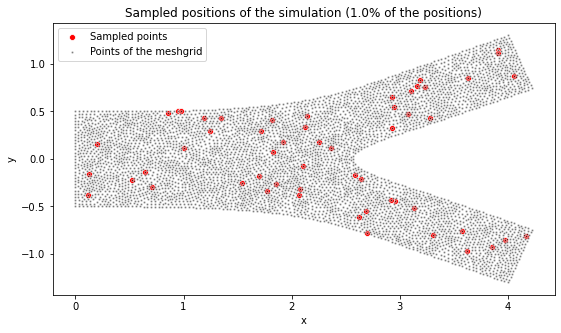

In [14]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a 2D matrices with dimensions $(N_s, (2 N_u),  N_t)$. For each simulation, the x and y speed coordinates are compressed to the following 2D matrix:



$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [15]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 110, 110)

Let's make a sanity check that the dimension of 1 datapoint is indeed $({2 * new_{N_t}, new_{N_u})}$.

In [16]:
assert flattened_array.shape[1] == 2*new_Nu
assert flattened_array.shape[2] == new_Nt

## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle. 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t.

In [17]:
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='lstm_very_small', lstm=True)

The cell above is only intented to be run __once__.

#### Start from here if you the pickle file already exist in your data folder <a name="start_pickle"></a>

Change only the following cell to change the name of the file you want to open.

In [46]:
ratios = [0.1, 0.5]
size = ['lstm_very_small', 'lstm_middle_small', 'lstm_small']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_lstm_very_small_0.1_0.5


In [47]:
flattened_array = cPickle.load(open("data/pickle/"+str(size[0])+"/"+name, "rb"))

In [48]:
print(flattened_array.shape)

(25, 1100, 55)


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [49]:
from sklearn.preprocessing import MinMaxScaler

for i in range(flattened_array.shape[0]):
    scaler = MinMaxScaler()
    scaler.fit(flattened_array[i])
    flattened_array[i] = scaler.transform(flattened_array[i])

In [50]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(22, 1100, 55)
(3, 1100, 55)


## 4. LSTM Auto-encoder  <a name="autoencoder"></a>

In [51]:
input_dim = 55
seq_len = 1100
hidden_size = 5
model = LSTMAE(input_dim, hidden_size)

In [52]:
model

LSTMAE(
  (encoder): Encoder(
    (lstm_encoder_1): LSTM(55, 48, batch_first=True)
    (lstm_encoder_2): LSTM(48, 32, batch_first=True)
    (lstm_encoder_3): LSTM(32, 5, batch_first=True)
  )
  (decoder): Decoder(
    (lstm_decoder_1): LSTM(5, 32, batch_first=True)
    (lstm_decoder_2): LSTM(32, 48, batch_first=True)
    (lstm_decoder_3): LSTM(48, 55, batch_first=True)
  )
)

In [53]:
# define network parameters
learningRate=1e-2
epochs=50
input_size=x_train.shape[2]
k_folds = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

In [32]:
Kfold_lstm(x_train, k_folds, input_dim, epochs, criterion, learningRate, 5)

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:1.076 Test Error:1.087
Epoch:2/50 Training Error:1.074 Test Error:1.085
Epoch:3/50 Training Error:1.071 Test Error:1.082
Epoch:4/50 Training Error:1.067 Test Error:1.078
Epoch:5/50 Training Error:1.063 Test Error:1.073
Epoch:6/50 Training Error:1.059 Test Error:1.068
Epoch:7/50 Training Error:1.054 Test Error:1.063
Epoch:8/50 Training Error:1.049 Test Error:1.057
Epoch:9/50 Training Error:1.043 Test Error:1.051
Epoch:10/50 Training Error:1.038 Test Error:1.045
Epoch:11/50 Training Error:1.032 Test Error:1.038
Epoch:12/50 Training Error:1.026 Test Error:1.032
Epoch:13/50 Training Error:1.021 Test Error:1.026
Epoch:14/50 Training Error:1.015 Test Error:1.019
Epoch:15/50 Training Error:1.009 Test Error:1.013
Epoch:16/50 Training Error:1.003 Test Error:1.006
Epoch:17/50 Training Error:0.998 Test Error:1.000
Epoch:18/50 Training Error:0.992 Test Error:0.993
Epoch:19/50 Training Error:0.986 Tes

KeyboardInterrupt: 

#### Parameters tuning

Find the best learning rate and momentums of our model using cross-validation :

In [54]:
# define network parameters
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] 
momentums = [0.1, 0.5, 0.7, 0.9, 0.99]
epochs= 50
input_size=x_train.shape[2]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name
hidden_size = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

In [ ]:
results, best_result, best_lr, best_mom = tuning_lr_momentum_lstm(x_train, k_folds, input_size, epochs, criterion, learning_rates, hidden_size, momentums, dataset_name_=dataset_name, plot=True)

Momentum =  0.1

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 0.661 	 Average Test Error: 0.663
 
Learning rate =  0.01



Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [ ]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[2]
k_folds = 5
hidden_sizes = [3, 5, 6, 8, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

In [ ]:
best_result, best_neurons_nb = tuning_latent_layer_lstm(x_train, k_folds, input_size, epochs, criterion, lr, hidden_sizes, dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [ ]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 3
hidden_size_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

In [ ]:
Kfold_lstm(x_train, k_folds, input_size, epochs, criterion, learningRate, hidden_size_)

#### Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [132]:
import glob
import os 
import _pickle as cPickle

dataset = 'middle_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= best_lr
hidden_size_ = best_neurons_nb

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []

for f in filenames:
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = LSTMAE(input_size, hidden_size_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch_lstm(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch_lstm(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch_lstm(test_loader, model)
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)

In [130]:
from pandas import *

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3],
                   '5%' : test_errors[3:6],
                   '2%' : test_errors[6:9]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

ValueError: All arrays must be of the same length

In [131]:
#Save in pickles

name = "lstm_train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "lstm_test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 5. Discussion & conclusion <a name="ccl"></a>